<a href="https://colab.research.google.com/github/ShamsulAbedin/CA684I/blob/master/Shamsul_CA684I_kaggle_MediaEval_C3D_HMP_testing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting video memorability using captions**


In [1]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 50kB/s 
     |████████████████████████████████| 3.2MB 34.4MB/s 
     |████████████████████████████████| 491kB 49.8MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [2]:
!pip install pyprind
!pip install keras

In [0]:
import pandas as pd

import numpy as np
from string import punctuation
t
import matplotlib.pyplot as plt
import os


In [0]:
from keras import Sequential
from keras import layers
from keras import regularizers
import tensorflow
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_spli

In [0]:
# for reproducability
from numpy.random import seed
seed(1)

In [0]:
import tensorflow
from tensorflow import set_random_seed
tensorflow.set_random_seed(1)

In [11]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, numpy, tensorboard, protobuf, termcolor, wrapt, astor, absl-py, keras-applications, grpcio, gast, google-pasta, wheel, keras-preprocessing, tensorflow-estimator
Required-by: fancyimpute




**Predicting Memorability**

Spearman correlation


In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# 1. Loading the captions and the memorability scores



In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df_cap = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df_cap['video']=vn
        df_cap['caption']=cap
    return df_cap

In [96]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/')

In [0]:
cap_path='/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

In [0]:

# load the ground truth values
label_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')


In [80]:
print(df_cap)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
...              ...                                                ...
5995  video7488.webm        beautiful-young-woman-in-front-of-fountains
5996  video7489.webm  focus-pull-from-molting-penguin-to-penguin-col...
5997  video7491.webm           students-walking-in-university-of-mexico
5998  video7492.webm                       beautiful-black-woman-at-spa
5999  video7493.webm  beautiful-modern-brunette-woman-using-tablet-c...

[6000 rows x 2 columns]


In [32]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [34]:
df_cap.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [35]:
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


#2. Cleaning / Pre-Processing

In [0]:
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re

## 2.1 Stripping special characters


In [0]:
df = df_cap.copy()
import re
def strip_character(dataCol):
    r = re.compile(r'[^a-zA-Z]')
    return r.sub(' ', str(dataCol))

df['caption'] = df['caption'].apply(strip_character)

In [40]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## 2.2 Removing Stopwords


In [0]:
stop = stopwords.words('english') 

## 2.3 Lemmatization


In [81]:
df['caption'] = df['caption'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                khr gangsters
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object

## 2.4 Extracting unique words count

In [0]:
counts = Counter()
for i, cap in enumerate(df['caption']):
    counts.update(cap.split())

In [44]:
df.caption.values

array(['blonde woman massaged tilt',
       'roulette table spinning ball closeup shot', 'khr gangsters', ...,
       'students walking university mexico', 'beautiful black woman spa',
       'beautiful modern brunette woman using tablet computer luxury bed'],
      dtype=object)

##	2.5 Trying an n-Gram approach- Using TF-IDF

In [0]:
vect = TfidfVectorizer(ngram_range = (1,4)).fit(df.caption)
vect_transformed_X_train = vect.transform(df.caption)
len_token = len(vect.get_feature_names())

In [46]:
len_token

59584

##	2.6 Maping each unique word to an integer (one-hot encoding)

In [0]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)


In [0]:
#fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

tokenizer.fit_on_texts(list(vect.get_feature_names()))

In [0]:
#sequences = tokenizer.texts_to_sequences(list(df.caption.values))

one_hot_res = tokenizer.texts_to_matrix(list(df.caption.values),mode='binary')


In [50]:
len(one_hot_res)

6000

#	3. Predicting video memorability using captions

In [51]:
one_hot_res.shape

(6000, 5098)

##	3.1 Recurrent Neural Network model

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [53]:
# add dropout
# add regularizers

model = Sequential()
model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(len_token,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='sigmoid'))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 504us/sample - loss: 0.0031 - acc: 0.8727 - val_loss: 0.0178 - val_acc: 0.6492
Epoch 2/20
4800/4800 [==============================] - 2s 389us/sample - loss: 0.0030 - acc: 0.8788 - val_loss: 0.0177 - val_acc: 0.6392
Epoch 3/20
4800/4800 [==============================] - 2s 368us/sample - loss: 0.0030 - acc: 0.8781 - val_loss: 0.0175 - val_acc: 0.6358
Epoch 4/20
4800/4800 [==============================] - 2s 372us/sample - loss: 0.0029 - acc: 0.8800 - val_loss: 0.0178 - val_acc: 0.6475
Epoch 5/20
4800/4800 [==============================] - 2s 371us/sample - loss: 0.0029 - acc: 0.8813 - val_loss: 0.0177 - val_acc: 0.6375
Epoch 6/20
4800/4800 [==============================] - 2s 370us/sample - loss: 0.0028 - acc: 0.8927 - val_loss: 0.0174 - val_acc: 0.6475
Epoch 7/20
4800/4800 [==============================] - 2s 372us/sample - loss: 0.0028 - acc: 0.8888 - val_loss: 0.0178 - va

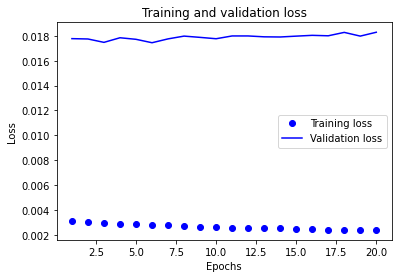

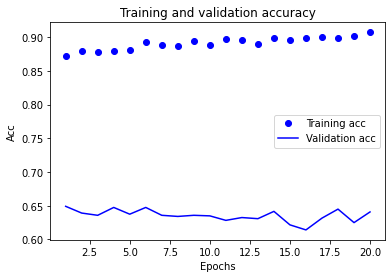

In [82]:
          
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [55]:
predictions = model.predict(X_test)
print(predictions.shape)


(1200, 2)


In [83]:
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.362
The Spearman's correlation coefficient is: 0.161


**Saving the model**

In [0]:
model.save('/content/drive/My Drive/CaptionPrdiction_NN.h5')  # creates a HDF5 file 'my_model.h5'

##	3.2 Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rf3 = RandomForestRegressor(n_estimators = 10, random_state = 0).fit(X_train, Y_train);

In [61]:
y_predict = rf3.predict(X_test)
Get_score(y_predict, Y_test)


The Spearman's correlation coefficient is: 0.395
The Spearman's correlation coefficient is: 0.183


##	3.3 Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression



In [0]:
modelLR = LinearRegression().fit(X_train, Y_train)

In [65]:
ynew = modelLR.predict(X_test)
Get_score(y_predict, Y_test)

The Spearman's correlation coefficient is: 0.395
The Spearman's correlation coefficient is: 0.183


##	3.4 Support Vector Machines - SVR

### SVR-Short Term memorablity

In [66]:
from sklearn.svm import SVR
Y_short = labels[['short-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100).fit(X_train,Y_train_short)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
from sklearn.svm import SVR
Y_short = labels[['short-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=100).fit(X_train,Y_train_short)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SVR-Long Term memorablity

In [0]:
Y_long = labels[['long-term_memorability']].values
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)


In [69]:
Y_test_long.shape
modelSVR_long = SVR(C=100).fit(X_train,Y_train_long)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)


The Spearman's correlation coefficient is: 0.182


##	3.5 Decision Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [0]:
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, Y_train)
pred_test_dtr = regr.predict(X_test)


In [73]:
Get_score(pred_test_dtr, Y_test)

The Spearman's correlation coefficient is: 0.227
The Spearman's correlation coefficient is: 0.103


#	4. Predicting video memorability using Video features

##	4.1 Using C3D feature

In [0]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0]+'.webm' for vn in vnames]
    return vid


In [0]:
C3D_Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values

C3D_Features = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(C3D_Feat_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })


In [0]:
C3D_X = np.stack(C3D_Features['C3D'].values)
C3D_Y = labels[['short-term_memorability','long-term_memorability']].values

C3D_X_train, C3D_X_test, C3D_Y_train, C3D_Y_test = train_test_split(C3D_X,C3D_Y, test_size=0.2, random_state=42)


###	4.1.1 Recurrent Neural Network

In [88]:
C3D_model = Sequential()
C3D_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(C3D_X.shape[1],)))
C3D_model.add(layers.Dropout(0.1))
C3D_model.add(layers.Dense(2,activation='sigmoid'))
C3D_model.compile(optimizer='rmsprop',loss=['mae'])
history=C3D_model.fit(x=C3D_X_train,y=C3D_Y_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)
C3D_Y_pred = C3D_model.predict(C3D_X_test)



Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 0s 92us/sample - loss: 0.1519 - val_loss: 0.0868
Epoch 2/20
3840/3840 [==============================] - 0s 41us/sample - loss: 0.0872 - val_loss: 0.0867
Epoch 3/20
3840/3840 [==============================] - 0s 38us/sample - loss: 0.0865 - val_loss: 0.0869
Epoch 4/20
3840/3840 [==============================] - 0s 39us/sample - loss: 0.0861 - val_loss: 0.0866
Epoch 5/20
3840/3840 [==============================] - 0s 42us/sample - loss: 0.0860 - val_loss: 0.0867
Epoch 6/20
3840/3840 [==============================] - 0s 39us/sample - loss: 0.0858 - val_loss: 0.0866
Epoch 7/20
3840/3840 [==============================] - 0s 37us/sample - loss: 0.0856 - val_loss: 0.0864
Epoch 8/20
3840/3840 [==============================] - 0s 40us/sample - loss: 0.0854 - val_loss: 0.0863
Epoch 9/20
3840/3840 [==============================] - 0s 38us/sample - loss: 0.0854 - val_loss: 0.0871
Epoch 10

In [89]:
Get_score(C3D_Y_pred,C3D_Y_test)

The Spearman's correlation coefficient is: 0.280
The Spearman's correlation coefficient is: 0.123


###	4.1.2 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
C3D_clf = RandomForestRegressor()
C3D_clf.fit(C3D_X_train,C3D_Y_train)
pred_test_rfr = C3D_clf.predict(C3D_X_test)

In [91]:
Get_score(pred_test_rfr, C3D_Y_test)

The Spearman's correlation coefficient is: 0.304
The Spearman's correlation coefficient is: 0.091


##	4.2 Using HMP feature

In [0]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP


In [0]:
HMP_Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values
HMP_Features = pd.DataFrame({'video': vid,
                   'HMP': [read_HMP(HMP_Feat_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })


In [0]:
HMP_X = np.stack(HMP_Features['HMP'].values)
HMP_Y = labels[['short-term_memorability','long-term_memorability']].values
HMP_X_train, HMP_X_test, HMP_Y_train, HMP_Y_test = train_test_split(HMP_X,HMP_Y, test_size=0.2, random_state=42)


###	4.2.1 Recurrent Neural Network



In [99]:
HMP_model = Sequential()
HMP_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(HMP_X.shape[1],)))
HMP_model.add(layers.Dropout(0.1))
HMP_model.add(layers.Dense(2,activation='sigmoid'))
HMP_model.compile(optimizer='rmsprop',loss=['mae'])
history=HMP_model.fit(x=HMP_X_train,y=HMP_Y_train,batch_size=50,epochs=20,validation_split=0.2,shuffle=True,verbose=True)
HMP_Y_pred = HMP_model.predict(HMP_X_test)



Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 2s 427us/sample - loss: 0.1521 - val_loss: 0.0865
Epoch 2/20
3840/3840 [==============================] - 1s 359us/sample - loss: 0.0887 - val_loss: 0.0862
Epoch 3/20
3840/3840 [==============================] - 1s 353us/sample - loss: 0.0879 - val_loss: 0.0858
Epoch 4/20
3840/3840 [==============================] - 1s 360us/sample - loss: 0.0877 - val_loss: 0.0856
Epoch 5/20
3840/3840 [==============================] - 1s 366us/sample - loss: 0.0876 - val_loss: 0.0862
Epoch 6/20
3840/3840 [==============================] - 1s 362us/sample - loss: 0.0874 - val_loss: 0.0858
Epoch 7/20
3840/3840 [==============================] - 1s 358us/sample - loss: 0.0875 - val_loss: 0.0860
Epoch 8/20
3840/3840 [==============================] - 1s 358us/sample - loss: 0.0874 - val_loss: 0.0860
Epoch 9/20
3840/3840 [==============================] - 1s 360us/sample - loss: 0.0873 - val_loss: 0.0855

In [100]:
Get_score(HMP_Y_pred,HMP_Y_test)

The Spearman's correlation coefficient is: 0.279
The Spearman's correlation coefficient is: 0.131


###	4.2.2 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
HMP_clf = RandomForestRegressor()
HMP_clf.fit(HMP_X_train,HMP_Y_train)
pred_test_rfr = HMP_clf.predict(HMP_X_test)



In [102]:
Get_score(pred_test_rfr, HMP_Y_test)

The Spearman's correlation coefficient is: 0.289
The Spearman's correlation coefficient is: 0.141


# 5. Final ground truth prediction-Test data

In [0]:
# load the captions
#cap_path = '/media/win/Users/ecelab-adm/Desktop/DataSet_me18me/me18me-devset/dev-set/dev-set_video-captions.txt'
cap_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
df_test=read_caps(cap_path)

# load the ground truth values
test_ground_truth=pd.read_csv('/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')

df_test['caption'] = df_test['caption'].apply(strip_character)

df_test['caption'] = df_test['caption'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df_test['caption'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',text)) for text in lis]) for lis in df_test['caption']]

counts_test = Counter()
for i, cap in enumerate(df_test['caption']):
    counts_test.update(cap.split())


In [0]:
vect_test = TfidfVectorizer(ngram_range = (1,4)).fit(df_test.caption)

In [0]:
# using the training data's words length for the testing as well to avoid the 
tokenizer_test = Tokenizer(num_words=len_token)
tokenizer_test.fit_on_texts(list(vect_test.get_feature_names()))
one_hot_res_test = tokenizer_test.texts_to_matrix(list(df_test.caption.values),mode='binary')
X_testpredict = one_hot_res_test;

In [0]:

np.ndim(one_hot_res_test)
one_hot_res_test.shape
testdata = test_ground_truth.copy()


## 5.1	Predicting short-term memorability - using SVR

In [0]:
testpredict_SVR_short = modelSVR_short.predict(X_testpredict)

In [0]:
testpredict_SVR_short.shape
type(testpredict_SVR_short)
testdata['short-term_memorability'] = testpredict_SVR_short


## 5.2 Predicting long-term memorability - using Random Forest

In [0]:
testpredict_RFR_long = rf3.predict(X_testpredict)

In [0]:
testdata['long-term_memorability'] = testpredict_RFR_long[:,1]

In [111]:
testdata.tail()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
1995,10004,0.821670,34,0.737700,17
1996,10005,0.818239,34,0.777900,9
1997,10006,0.833838,34,0.796867,12
1998,10007,0.854636,34,0.820600,12
1999,10008,0.848433,33,0.866900,10


# 6.Saving the final submission file

In [0]:
testdata.to_csv('/content/drive/My Drive/finalgroundTruth_test.csv', encoding='utf-8', index=False)